### Import libraries

In [1]:
import numpy as np
import os, time
import matplotlib.pyplot as plt
import itertools
import pickle
import imageio
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.tensorboard import SummaryWriter

### Availability of Cuda

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

### Tensorboard

In [3]:
# Writer will output to ./runs/ directory by default
tb_writer = SummaryWriter()

### Import data

In [4]:
image_size = 64
transforms = transforms.Compose([ transforms.Resize(image_size), 
                                 transforms.ToTensor(), 
                                 transforms.Normalize(mean=(0.5), std = (0.5))])

data_train = datasets.MNIST('.\data', train = True, download = True, transform = transforms)

### Data Loader

In [5]:
batch_size = 128

train_loader = torch.utils.data.DataLoader(data_train, batch_size = batch_size, shuffle = True, num_workers = 2)

### Data preprocessing

In [6]:
None

### Visualize preprocessed data

In [7]:
real_batch = next(iter(train_loader))
real_batch[0].shape

torch.Size([128, 1, 64, 64])

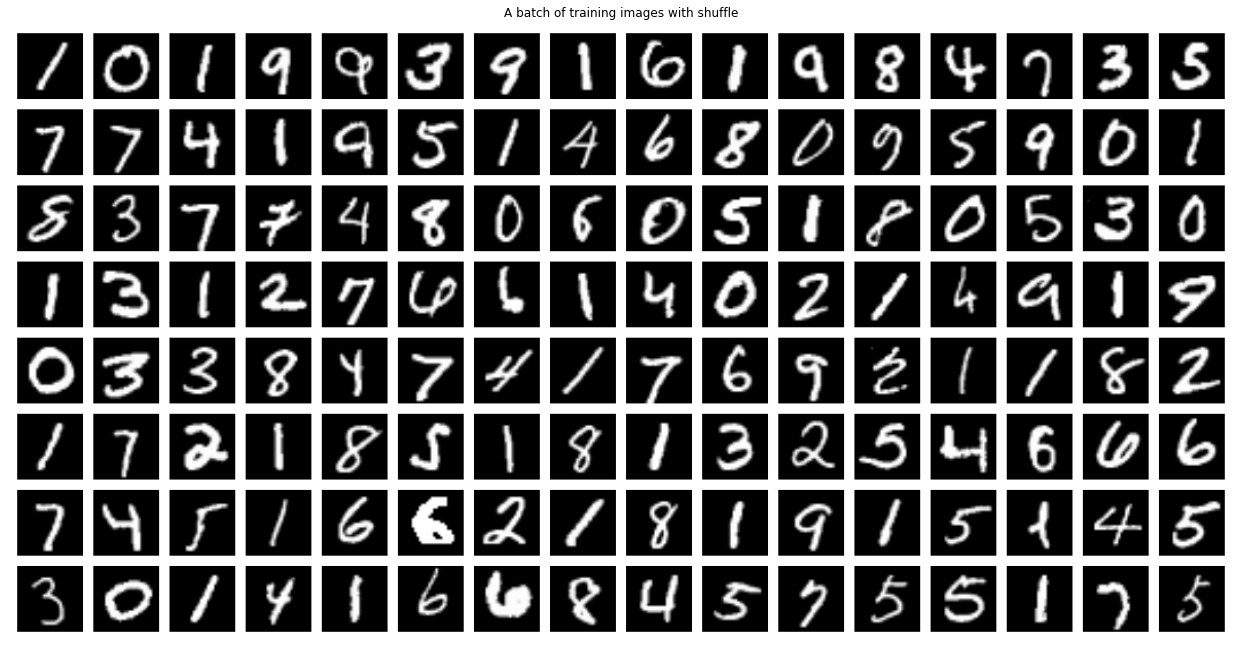

In [8]:
real_batch = next(iter(train_loader))

plt.figure(figsize=(22, 12))
plt.axis('off')
plt.title('A batch of training images with shuffle')
plt.imshow(np.transpose(torchvision.utils.make_grid(
                        real_batch[0].to(device),
                        padding=10,
                        normalize = True,
                        pad_value=1,
                        nrow=int(len(real_batch[0])/8)).cpu(), (1,2,0)))
plt.show()

### Generator class architecture

In [9]:
# G(z)

class generator(nn.Module):
    # initializers
    def __init__(self, d = 128):
        super(generator, self).__init__()
        self.deconv1 = nn.ConvTranspose2d(100, d*8, 4, 1, 0) # in_channels,out_channels, kernel_size, stride, padding
        self.deconv1_bn = nn.BatchNorm2d(d*8) # num_features
        
        self.deconv2 = nn.ConvTranspose2d(d*8, d*4, 4, 2, 1) 
        self.deconv2_bn = nn.BatchNorm2d(d*4)
        
        self.deconv3 = nn.ConvTranspose2d(d*4, d*2, 4, 2, 1)
        self.deconv3_bn = nn.BatchNorm2d(d*2)
        
        self.deconv4 = nn.ConvTranspose2d(d*2, d, 4, 2, 1)
        self.deconv4_bn = nn.BatchNorm2d(d)
        
        self.deconv5 = nn.ConvTranspose2d(d, 1, 4, 2, 1)
        
    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)
            
    # forward method
    def forward(self, input):
        x = F.relu(self.deconv1_bn(self.deconv1(input)))
        x = F.relu(self.deconv2_bn(self.deconv2(x)))
        x = F.relu(self.deconv3_bn(self.deconv3(x)))
        x = F.relu(self.deconv4_bn(self.deconv4(x)))
        x = torch.tanh(self.deconv5(x))
        
        return x


#### Visualize generator class architecture

https://github.com/ashishpatel26/Tools-to-Design-or-Visualize-Architecture-of-Neural-Network

https://stackoverflow.com/questions/52468956/how-do-i-visualize-a-net-in-pytorch

https://www.machinecurve.com/index.php/2020/02/27/visualizing-your-neural-network-with-netron/

### Discriminator class architecture

In [10]:
class discriminator(nn.Module):
    # initializers
    def __init__(self, d = 128):
        super(discriminator, self).__init__()
        self.conv1 = nn.Conv2d(1, d, 4, 2, 1
                              )
        self.conv2 = nn.Conv2d(d, d*2, 4, 2, 1)
        self.conv2_bn = nn.BatchNorm2d(d*2)
        
        self.conv3 = nn.Conv2d(d*2, d*4, 4, 2, 1)
        self.conv3_bn = nn.BatchNorm2d(d*4)
        
        self.conv4 = nn.Conv2d(d*4, d*8, 4, 2, 1)
        self.conv4_bn = nn.BatchNorm2d(d*8)
        
        self.conv5 = nn.Conv2d(d*8, 1, 4, 1, 0)
        
    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)
            
    # forward method
    def forward(self, input):
        x = F.leaky_relu(self.conv1(input), 0.2)
        x = F.leaky_relu(self.conv2_bn(self.conv2(x)), 0.2)
        x = F.leaky_relu(self.conv3_bn(self.conv3(x)), 0.2)
        x = F.leaky_relu(self.conv4_bn(self.conv4(x)), 0.2)
        x = torch.sigmoid(self.conv5(x))
        return x

#### Visualize discriminator class architecture

### Noise

fixed vs. random

In [11]:
def normal_init(m, mean, std):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        m.weight.data.normal_(mean, std)
        m.bias.data.zero_()
        
fixed_z_ = torch.randn((5*5), 100).view(-1, 100, 1, 1).to(device)  # fixed noise

### Network

lr, loss, optimize, instance of generator and discriminator networks

In [12]:
lr = 0.0002

G = generator(128)
D = discriminator(128)
G.weight_init(mean=0.0, std=0.02)
D.weight_init(mean=0.0, std=0.02)
G.cuda()
D.cuda()

# Binary Cross Entropy loss
BCE_loss = nn.BCELoss()

# Adam optimizer
G_optimizer = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
D_optimizer = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))

### Show results function

In [13]:
def show_result(num_epoch, grid, path, show = False, save = True):
      
    plt.figure(figsize=(16, 12))
    
    plt.axis('off')
    plt.title('Generated Images')
    label = 'Epoch {0}'.format(num_epoch)
    plt.text(0.5, 0.04, label, ha='center')
    plt.imshow(np.transpose(grid, (1,2,0)))
    
    
    plt.savefig(path)
    
    
    if show:
        plt.show()
    else:
        plt.close()

### Show training history function

In [14]:
def show_train_history(hist, show = False, save = True, path = 'Train_hist.png'):
    x = range(len(hist['D_losses']))
    
    y1 = hist['D_losses']
    y2 = hist['G_losses']
    
    plt.plot(x, y1, label = 'D_loss')
    plt.plot(x, y2, label = 'G_loss')
    
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    
    plt.legend(loc = 4)
    plt.grid(True)
    plt.tight_layout()
    
    if save:
        plt.savefig(path)
        
    if show:
        plt.show()
    else:
        plt.close()

### Training parameters
Batch size, num_epochs

In [15]:
batch_size = 128
train_epoch = 20

### Results save folder

In [16]:
# results save folder
if not os.path.isdir('MNIST_DCGAN_results'):
    os.mkdir('MNIST_DCGAN_results')
if not os.path.isdir('MNIST_DCGAN_results/Random_results'):
    os.mkdir('MNIST_DCGAN_results/Random_results')
if not os.path.isdir('MNIST_DCGAN_results/Fixed_results'):
    os.mkdir('MNIST_DCGAN_results/Fixed_results')

### Start training

store results in tensor board

In [ ]:
D_losses = []
G_losses = []
per_epoch_times = []

print('training started!')
start_time = time.time()

for epoch in range(train_epoch):
    epoch_start_time = time.time()
    
    for images, labels in train_loader:
        
        # train discriminator D (temporarily one epoch only)
        D.zero_grad()
        
        # images shape from train_loader is torch.Size([128, 1, 64, 64])
        mini_batch = images.size()[0] # 128
        images = images.to(device)
        real_labels = torch.ones(mini_batch).to(device) # because sigmoid produces 2d output.
        fake_labels = torch.zeros(mini_batch).to(device) # because sigmoid produces 2d output.
        
        # applying discriminator to real images
        real_outputs = D(images).squeeze() # will squeeze output of shape [128,1,1,1] to [128]
        D_real_loss = BCE_loss(real_outputs, real_labels)
        
        # applying discriminator to fake images
        fake_noise = torch.randn(mini_batch, 100).view(-1, 100, 1, 1).to(device) # 100 is noise dimension
        # shape of fake noise is torch.size([128, 100, 1, 1])
        fake_outputs = D(G(fake_noise)).squeeze() # will squeeze output of shape [128,1,1,1] to [128]
        D_fake_loss = BCE_loss(fake_outputs, fake_labels)
        
        D_train_loss = D_real_loss + D_fake_loss

        D_train_loss.backward()
        D_optimizer.step()
        
        D_losses.append(D_train_loss)
        
        # train generator G
        G.zero_grad()
        
        # applying discriminator to fake images (G(fake_noise))
        fake_des_outputs = D(G(fake_noise)).squeeze()
        
        G_train_loss = BCE_loss(fake_des_outputs, real_labels)
        G_train_loss.backward()
        G_optimizer.step()
        
        G_losses.append(G_train_loss.data)
    
    epoch_end_time = time.time()
    per_epoch_time = epoch_end_time - epoch_start_time
    per_epoch_times.append(per_epoch_time)
    
    
    # applying tensor board logging
    if epoch % 2== 0:
        # G & D Loss
        print("Epoch:{}, per epoch time:{}, G Loss:{}, D Loss:{}".format(epoch, per_epoch_time, G_train_loss, D_train_loss))
        #in case multiple cycles of training for discrminator see commented code below
        #print("E:{}, G Loss:{}, D Loss:{}".format(epoch, g_loss/num_steps, d_loss/num_steps/4))
        
        # Tensorboards Logging
        tb_writer.add_scalar('MNIST_DCGAN/D Loss', D_train_loss, epoch)
        
        tb_writer.add_scalar('MNIST_DCGAN/G Loss', G_train_loss, epoch)
        
        # need to put fixed vs random noise (if else statement)
        
        # if len(noise) == len(fixed_noise):
        
        generated_images = G(fake_noise).detach().cpu().view(-1, 1, 64, 64)
        grid = torchvision.utils.make_grid(generated_images, nrow = 5, padding=10, pad_value=1, normalize=True)
        tb_writer.add_image('MNIST_DCGAN/Output', grid, epoch)

        fixed_p = 'MNIST_DCGAN_results/Fixed_results/MNIST_DCGAN_' + str(epoch) + '.png'
        show_result(epoch, grid, path=fixed_p, save=True)

#         else:
#             generated_images = G(randomd_noise).detach().cpu().view(-1, 1, 28, 28)
#             grid = torchvision.utils.make_grid(generated_images, nrow = 5, padding=10, pad_value=1, normalize=True)
#             tb_writer.add_image('MNIST_DCGAN/Output', grid, epoch)

#             p = 'MNIST_GAN_results/Random_results/MNIST_GAN_' + str(epoch + 1) + '.png'
#             show_result(grid, path=p, save=True)

# discriminator training of real images
tb_writer.add_graph(D, images) # flatten_real_images dimension is 60 x 784

# discriminator training of fake_noise
#tb_writer.add_graph(D, G(fake_noise)) G(fake_noise dimension is 60 x 784)

# geneartor training graph
#tb_writer.add_graph(G, torch.randn(mini_batch, 100).to(device)) # 100 is noise dimension hence input is 60 x 100

end_time = time.time()
total_training_time = end_time - start_time

print('Total training time is: ', total_training_time)
print("Training finished!... Saving training results")

# Save state dict of generator and discriminator

torch.save(G.state_dict(), "MNIST_DCGAN_results/generator_param.pkl")
torch.save(D.state_dict(), "MNIST_DCGAN_results/disciminator_param.pkl")
        

        
        
        
        
        


training started!
Epoch:0, per epoch time:794.9510169029236, G Loss:55.73041915893555, D Loss:6.376754299708409e-06
Epoch:2, per epoch time:784.5747272968292, G Loss:55.464500427246094, D Loss:5.17826379109465e-07
Epoch:4, per epoch time:787.2279582023621, G Loss:55.304805755615234, D Loss:5.463770236247001e-08
Epoch:6, per epoch time:786.6258647441864, G Loss:55.46189498901367, D Loss:3.849469010219764e-08
Epoch:8, per epoch time:785.1277244091034, G Loss:55.30225372314453, D Loss:8.19564718312904e-08
Epoch:10, per epoch time:793.3028836250305, G Loss:55.273895263671875, D Loss:9.934111311338256e-09
Epoch:12, per epoch time:1377.467651128769, G Loss:54.882652282714844, D Loss:2.4835271617007493e-09


### Save state dict of generator and discriminator

save train history as well

In [ ]:
images = []

for e in range(train_epoch):
    if e%2 == 0:
        img_name = 'MNIST_DCGAN_results/Fixed_results/MNIST_DCGAN_' + str(e) + '.png'
        print(img_name)
        images.append(imageio.imread(img_name))

    imageio.mimsave('MNIST_DCGAN_results/generation_animation.gif', images, fps = 0.5)